# IMDB Sentiment Analysis using LSTM

by Afnan Alabdan

## Introduction

In this project, the goal is to analyze customers' sentiment towards a product by performing sentiment analysis on user reviews from IMDB. Sentiment analysis is a widely used natural language processing (NLP) task that involves the classification of text into positive or negative based on the underlying sentiment. To perform sentiment analysis, we will be using a recurrent neural network (RNN), a deep learning model that can analyze sequences of data, such as text. By training an RNN on a dataset of IMDB reviews labeled with their corresponding sentiment, we aim to develop a system that can accurately predict the sentiment of new, unseen reviews. The insights gained from this analysis can be used by businesses to understand customer feedback and improve their products and services.

# Import software libraries and load the dataset

In [1]:
import numpy as np                     # Work with multi-dimensional arrays and matrices.
from numpy.random import seed
import matplotlib as mpl               # Create 2D charts.
import matplotlib.pyplot as plt
import sklearn                         # Perform data mining and analysis.
import tensorflow                      # Train neural networks for deep learning.
import keras                          
from keras import datasets

# Load the dataset.
(X_train, y_train), (X_test, y_test) = datasets.imdb.load_data(num_words = 10000)
print('Loaded {} training records.'.format(len(X_train.data)))
print('Loaded {} test records.'.format(len(X_test.data)))

# make outcomes deterministic
seed(1)
tensorflow.random.set_seed(1)

Loaded 25000 training records.
Loaded 25000 test records.


# Get acquainted with the dataset

In [2]:
print('First example features:\n')
print(X_train[0])
print('\n')
print('Label: {}'.format(y_train[0]))

First example features:

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Label: 1


In [3]:
# Decode sequence values into actual text.
index = datasets.imdb.get_word_index()
index_dict = dict([(value, key) for (key, value) in index.items()])
decode = ' '.join([index_dict.get(i - 3, '?') for i in X_train[0]])  # Replace unknown words with '?'.
print(decode) 

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

# Examine some statistics about the reviews

In [4]:
result = [len(i) for i in X_train]
print('Mean review length (in words): {:.0f}'.format(np.mean(result)))
print('Standard deviation (in words): {:.0f}'.format(np.std(result)))

Mean review length (in words): 239
Standard deviation (in words): 176


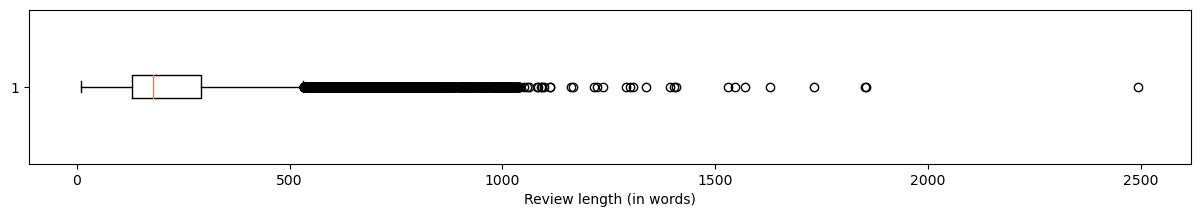

In [5]:
plt.figure(figsize = (15, 2))
plt.boxplot(result, vert = False)
plt.xlabel('Review length (in words)')
plt.show()

# Add padding to the data

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen = 500)
X_test = pad_sequences(X_test, maxlen = 500)

print('Number of features: {}'.format(X_train.shape[1]))

Number of features: 500


# Split the datasets

In [7]:
from sklearn.model_selection import train_test_split

# Split the training and validation datasets and their labels.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 50)

print(f'Training features:         {X_train.shape}')
print(f'Validation features:       {X_val.shape}')
print(f'Training labels:           {y_train.shape}')
print(f'Validation labels:         {y_val.shape}')

Training features:         (18750, 500)
Validation features:       (6250, 500)
Training labels:           (18750,)
Validation labels:         (6250,)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

monitor_val_auc = EarlyStopping(monitor = 'val_accuracy' , patience = 3)

# Build the RNN structure

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

rnn = Sequential()

# Start stacking layers one-by-one.
rnn.add(Embedding(input_dim = 10000,  # Size of vocabulary (the top 10,000 words).
                  output_dim = 100,  # 100-dimensional vector embedding.
                  input_length = 500))  # Length of review (in words).

rnn.add(LSTM(units = 64))  

rnn.add(Dense(128, activation='LeakyReLU'))

rnn.add(Dense(1, activation = 'sigmoid'))  # Dense output layer with sigmoid activation.

# Compile the model and examine the layers

In [10]:
rnn.compile(optimizer = 'adam',
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,050,689
Trainable params: 1,050,689
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [11]:
rnn_trained = rnn.fit(X_train, y_train,
                      validation_data = (X_val, y_val),
                      epochs = 10,
                      callbacks = [monitor_val_auc],
                      verbose = 1)

Epoch 1/10
586/586 [==============================] - 180s 303ms/step - loss: 0.4011 - accuracy: 0.8159 - val_loss: 0.3034 - val_accuracy: 0.8752
Epoch 2/10
586/586 [==============================] - 184s 314ms/step - loss: 0.2351 - accuracy: 0.9113 - val_loss: 0.3307 - val_accuracy: 0.8691
Epoch 3/10
586/586 [==============================] - 186s 318ms/step - loss: 0.1660 - accuracy: 0.9380 - val_loss: 0.3587 - val_accuracy: 0.8709
Epoch 4/10
586/586 [==============================] - 187s 319ms/step - loss: 0.1233 - accuracy: 0.9561 - val_loss: 0.4783 - val_accuracy: 0.8656


# Evaluate the model on the test data

In [12]:
eval_test = rnn.evaluate(X_test, y_test, verbose = 0)

print('Accuracy: {:.0f}%'.format(eval_test[1] * 100))

Accuracy: 86%


# Make predictions on the test data

In [18]:
prediction = rnn.predict(X_test)  

782/782 [==============================] - 47s 60ms/step


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85     12500
           1       0.82      0.90      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



# Examine a review that was correctly classified

In [14]:
label_names = ['negative', 'positive']

for i in range(100):
    if y_test[i] == prediction[i]:
        print('Actual review sentiment:    {}'.format(label_names[y_test[i]]))
        print('Predicted review sentiment: {}\n'.format(label_names[prediction[i]]))
        
        decode = ' '.join([index_dict.get(x - 3, '?') for x in X_test[i]])
        
        print(decode)
        
        break

Actual review sentiment:    negative
Predicted review sentiment: negative

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? please give this one a miss br br ? ? and the rest of the c

# Examine a review that was incorrectly classified

In [15]:
for i in range(100):
    if y_test[i] != prediction[i]:
        print('Actual review sentiment:    {}'.format(label_names[y_test[i]]))
        print('Predicted review sentiment: {}\n'.format(label_names[prediction[i]]))
        
        decode = ' '.join([index_dict.get(x - 3, '?') for x in X_test[i]])
        
        print(decode)
        
        break

Actual review sentiment:    negative
Predicted review sentiment: positive

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown